# 2D GAN of s1 vs s2 - 3/12/19

s1 vs s2 is an important relationship for the GAN to understand and to be able to recreate. This notebook creates a GAN which accurately recreates a 2D histogram. It is completed in Google Colab for the extra computing power it offered.

We try to compare the 2D distribution, but it is best to split the distribution to s1 and s2 to compare with G4DS data. 

In [1]:
pip install uproot

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd gdrive/My\ Drive/Masters_Project/dark_matter_7_12_19

/content/gdrive/My Drive/Masters_Project/dark_matter_7_12_19


Import relevant libraries & use uproot to open it.

In [0]:
import uproot
import pandas
import matplotlib.pyplot as plt
import numpy as np

tree = uproot.open("dark_matter_100kev_v1.root")["dstree"]

## Understand the data

The different variables contained within the tree. This is usually done at the start of every Jupyter notebook to allow me to make sure I have the variables and the types of the variables available. Generally this is good habit and is something I would recommend. 

If you have problems with a variable, I would strongly recommend opening the file in a TBrowser in root.

Some variables are given as lists of lists, and therefore need to be 'unpacked'.

The different variables contained within the tree.

In [5]:
tree.show()

ev                         (no streamer)              asdtype('>i4')
pdg                        (no streamer)              asdtype('>i4')
ene0                       (no streamer)              asdtype('>f4')
s1ene                      (no streamer)              asdtype('>f4')
s2ene                      (no streamer)              asdtype('>f4')
veto_visene                (no streamer)              asdtype('>f4')
mu_visene                  (no streamer)              asdtype('>f4')
vetoene                    (no streamer)              asdtype('>f4')
muene                      (no streamer)              asdtype('>f4')
tpcene                     (no streamer)              asdtype('>f4')
x                          (no streamer)              asdtype('>f4')
y                          (no streamer)              asdtype('>f4')
z                          (no streamer)              asdtype('>f4')
ene                        (no streamer)              asdtype('>f4')
r                          (no str

## Getting the s1 and s2 variables

From the list of variables stored in the root file, we can extract the relevant variables we would like to use to create a 2D histogram. Some of these variables may require further manipulation, and this is also done here.

norm1 and norm2 must be calualted by plotting the graph then finding the normalisation to make them both the same order of magnitude. 

(1000,)


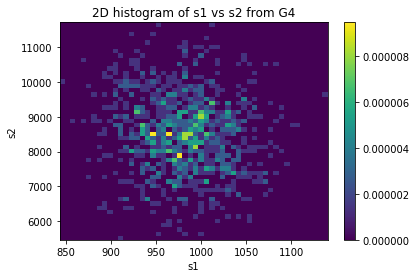

In [6]:
s1 = np.array(tree.array("s1"))
s2 = np.array(tree.array("s2"))
a1 = s1 / s1.max()
a2 = s2 / s2.max()
print(a1.shape)
train = np.matrix([a1,a2])
train = train.T
train = np.array(train)
plt.hist2d(a1 * s1.max(), a2 * s2.max(), bins=50, density=True)
plt.xlabel(f"s1")
plt.ylabel(f"s2")
plt.title("2D histogram of s1 vs s2 from G4")
plt.colorbar()
plt.show()

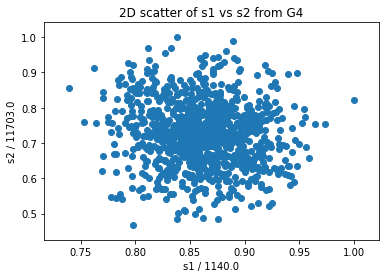

In [7]:
plt.scatter(a1, a2)
plt.xlabel(f"s1 / {round(s1.max())}")
plt.ylabel(f"s2 / {round(s2.max())}")
plt.title("2D scatter of s1 vs s2 from G4")  
plt.show()

We then set the number of training examples and the size of the noise. In this case, I set the noise size to 1000, thinking it had to be the same as the training data. However this is not the case, as the generator will transform the noise data into the appropriate number of points. 

Something that may be interesting to explore later is the effect of **varying the size of the noise** 

In [0]:
num_train = int(1e2)
noise_size = 1000
epochs     = 4000
batch_size = 1000

## Creation of the GAN

After setting some variables, the GAN is created. Generally there is no 'official documentation' on the correct setup of either the generator or disciminator. However the output of the disciminator should be a softmax, so it outputs a probability of the point being real/fake.

Binary Crossentropy is used to compare a probability (probaility image is real) with a 0,1 which is if it is real or fake. 

The generator is trying to maximise this, and make the disciminator bad at telling the difference, whilst the disciminator is trying to minimise this. 

A simple overview is found on this website: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

Using TensorFlow backend.







Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 82        
Total params: 1,842
Trainable params: 1,842
Non-trainable params: 0
_________________________________________________________________

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               100100    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
__________________________

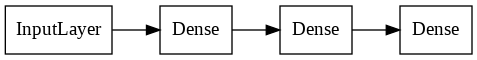

In [9]:
#  Create GAN

from keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU
from keras.models     import Model, Sequential
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

#Discriminator
#See how number of neurons are sae for each layer to reduce number of hyperparameters
d = Sequential(name="Discriminator")
d.add(Dense(40, activation="relu", input_shape=(2,)))
#Input shape would be number of parameters
d.add(Dense(40, activation="relu"))
#d.add(LeakyReLU(0.2))
d.add(Dense(2, activation="softmax"))
d.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.3), metrics=["accuracy"])
d.summary()

g = Sequential(name="Generator")
g.add(Dense(100, activation="relu", input_shape=(noise_size,)))
g.add(BatchNormalization())
g.add(Dense(100, activation="relu"))
#THe number of outputs here should be the number of dimensions
g.add(Dense(2, activation="linear"))
g.summary()

input_layer = Input((noise_size,))
output_layer = d(g(input_layer))
gan = Model(input_layer, output_layer)
d.trainable = False
gan.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.3), metrics=["accuracy"])
gan.summary()
plot_model(d, to_file='d.png',show_shapes = False, show_layer_names = False, rankdir='LR')
#plot_model(g, to_file='g.png',show_shapes = False, show_layer_names = False, rankdir='LR')


In [0]:
def noisegenerator(batch_size, noise_size):
    return np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Discriminator loss: 0.7722756
Discriminator acc: 0.5


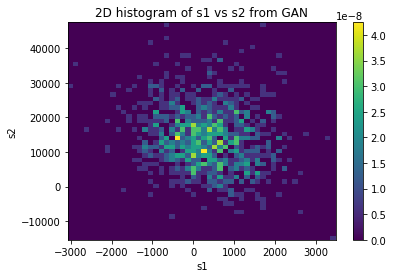

Discriminator loss: 0.66672766
Discriminator acc: 0.7555


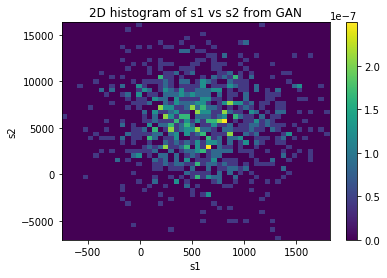

Discriminator loss: 0.66731656
Discriminator acc: 0.5


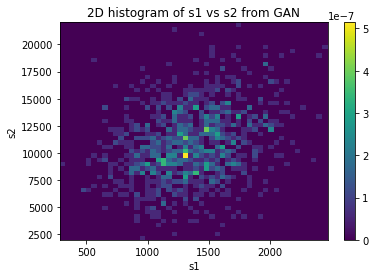

Discriminator loss: 0.67029834
Discriminator acc: 0.73


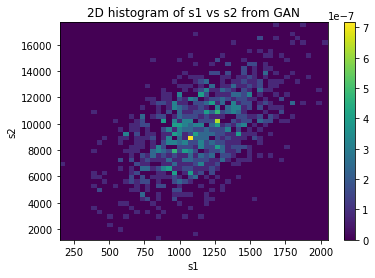

Discriminator loss: 0.68011814
Discriminator acc: 0.643


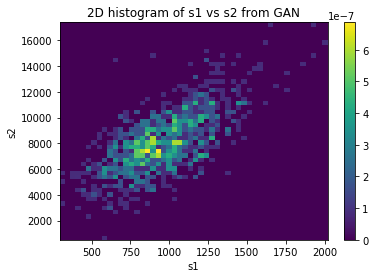

Discriminator loss: 0.6855168
Discriminator acc: 0.6475


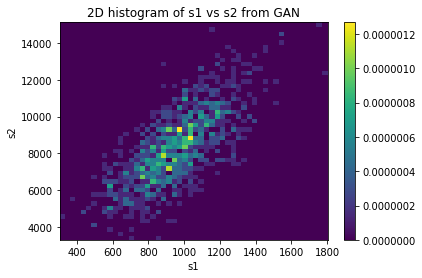

Discriminator loss: 0.6865099
Discriminator acc: 0.6095


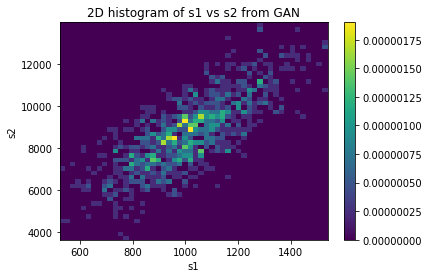

Discriminator loss: 0.68565965
Discriminator acc: 0.6165


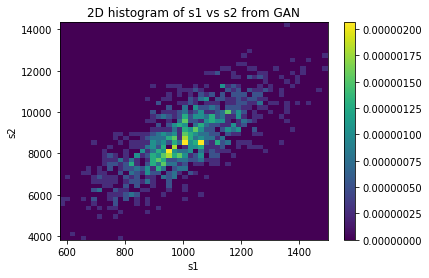

Discriminator loss: 0.6843319
Discriminator acc: 0.639


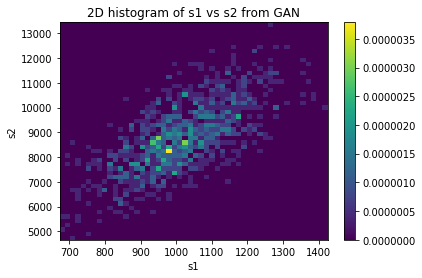

Discriminator loss: 0.68660426
Discriminator acc: 0.663


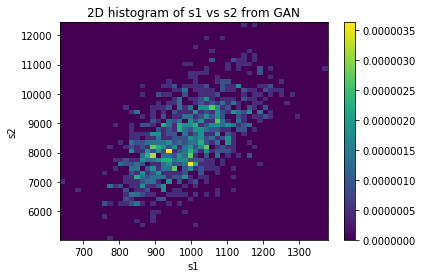

Discriminator loss: 0.68868905
Discriminator acc: 0.6355


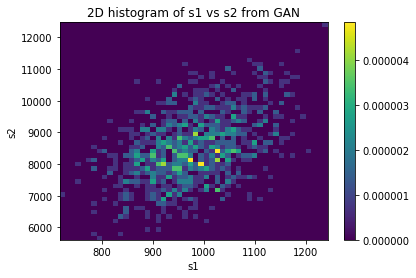

Discriminator loss: 0.68981946
Discriminator acc: 0.6215


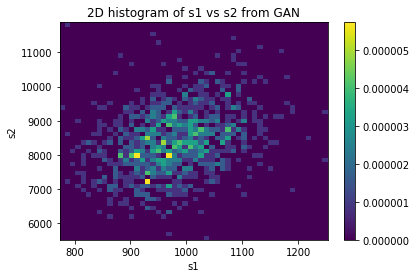

Discriminator loss: 0.6907108
Discriminator acc: 0.5865


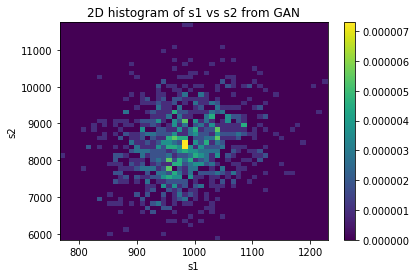

Discriminator loss: 0.69123
Discriminator acc: 0.552


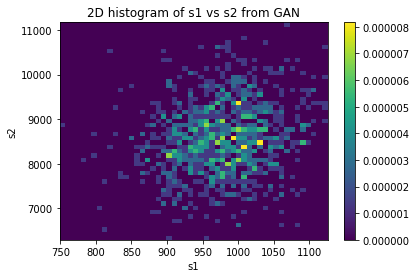

Discriminator loss: 0.6910218
Discriminator acc: 0.579


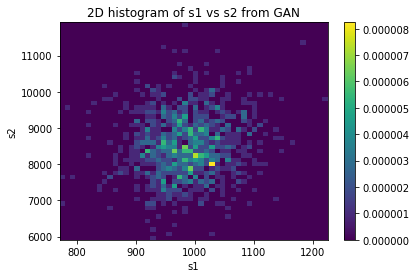

Discriminator loss: 0.69216055
Discriminator acc: 0.5445


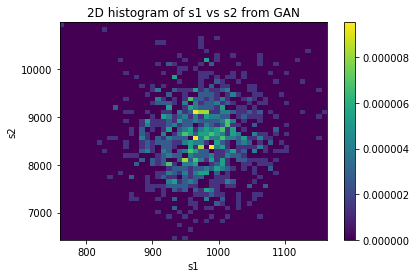

Discriminator loss: 0.6927157
Discriminator acc: 0.511


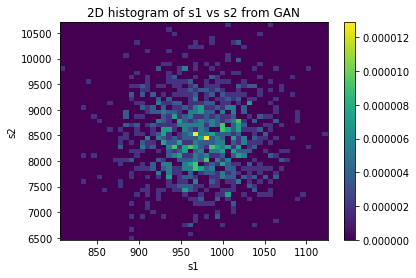

Discriminator loss: 0.6935856
Discriminator acc: 0.475


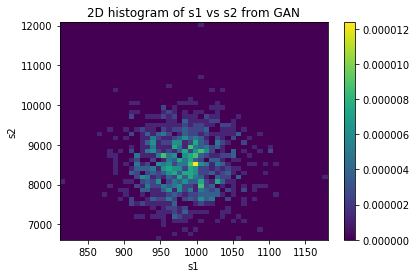

Discriminator loss: 0.69316375
Discriminator acc: 0.484


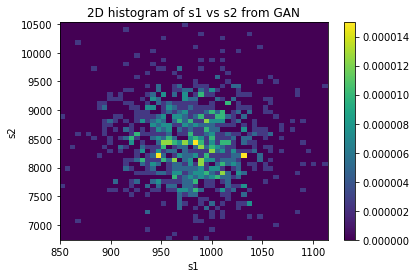

Discriminator loss: 0.6931577
Discriminator acc: 0.5


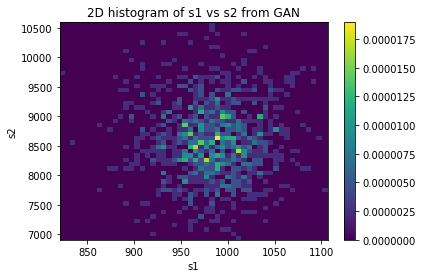

Discriminator loss: 0.69314855
Discriminator acc: 0.47


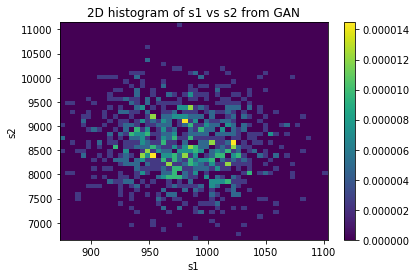

Discriminator loss: 0.6936569
Discriminator acc: 0.5005


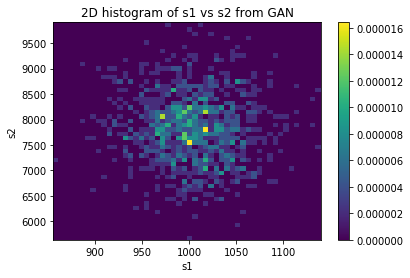

Discriminator loss: 0.6925389
Discriminator acc: 0.5


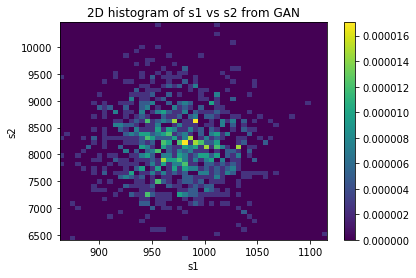

Discriminator loss: 0.6925036
Discriminator acc: 0.5


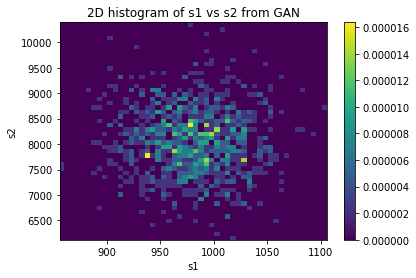

Discriminator loss: 0.6929841
Discriminator acc: 0.5


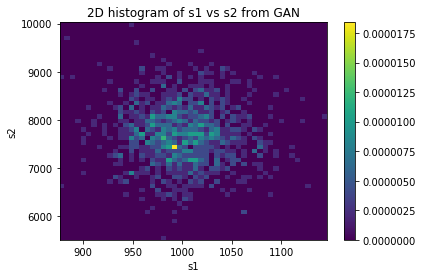

Discriminator loss: 0.6935968
Discriminator acc: 0.509


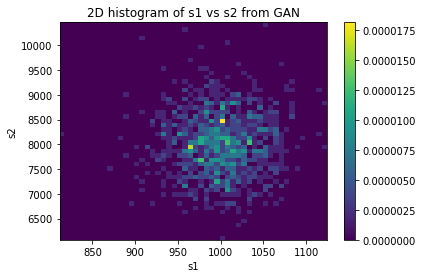

Discriminator loss: 0.6926688
Discriminator acc: 0.5


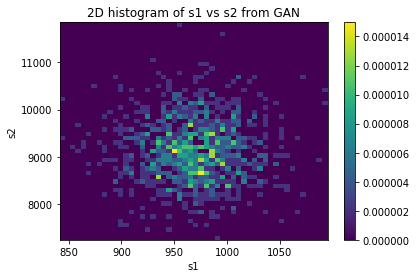

Discriminator loss: 0.6935192
Discriminator acc: 0.396


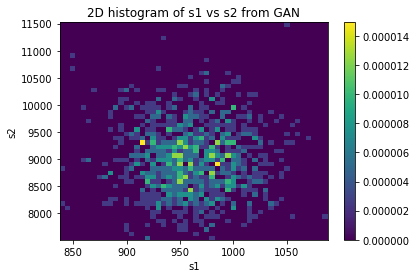

Discriminator loss: 0.6928654
Discriminator acc: 0.5


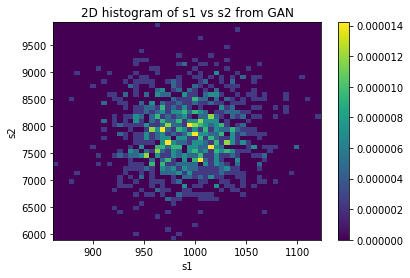

Discriminator loss: 0.69335157
Discriminator acc: 0.5135


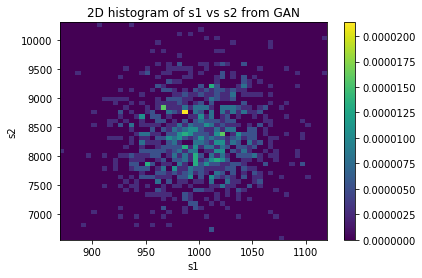

Discriminator loss: 0.69304883
Discriminator acc: 0.5


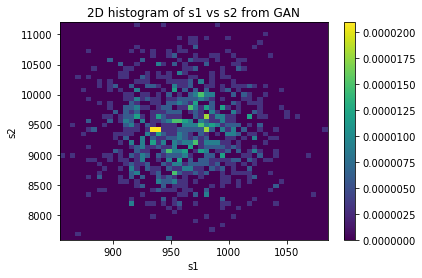

Discriminator loss: 0.69322646
Discriminator acc: 0.4725


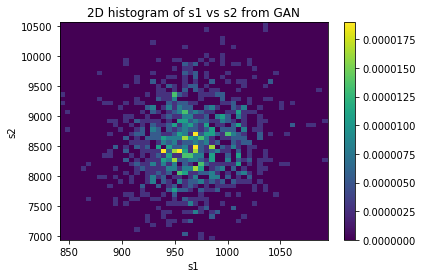

Discriminator loss: 0.6932395
Discriminator acc: 0.502


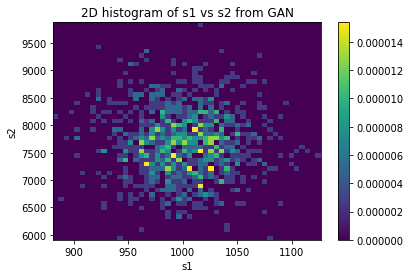

Discriminator loss: 0.6930094
Discriminator acc: 0.5005


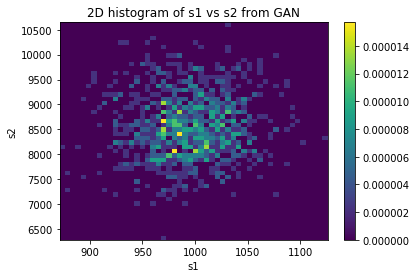

Discriminator loss: 0.69354934
Discriminator acc: 0.5


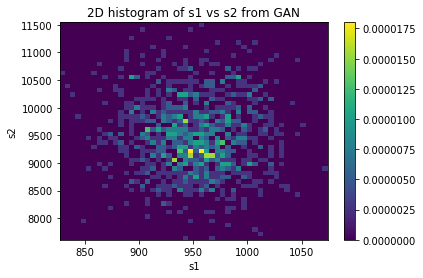

Discriminator loss: 0.69245994
Discriminator acc: 0.5


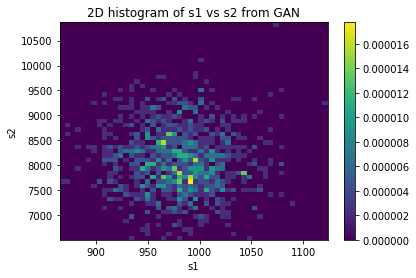

Discriminator loss: 0.69375306
Discriminator acc: 0.3985


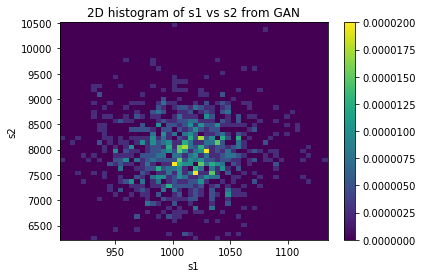

Discriminator loss: 0.69308835
Discriminator acc: 0.5


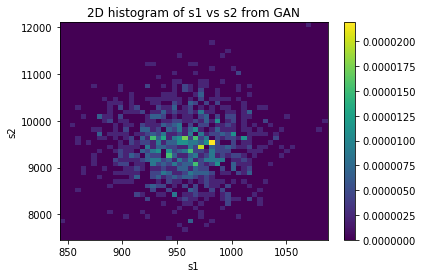

Discriminator loss: 0.6925946
Discriminator acc: 0.5


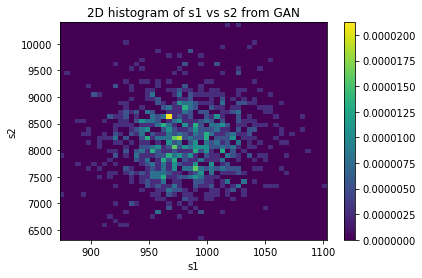

Discriminator loss: 0.6936949
Discriminator acc: 0.3635


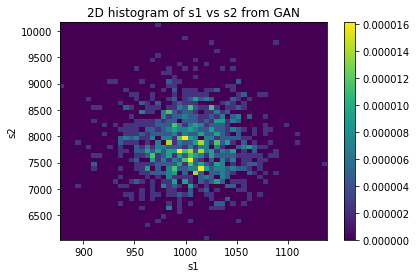

Discriminator loss: 0.6931149
Discriminator acc: 0.5


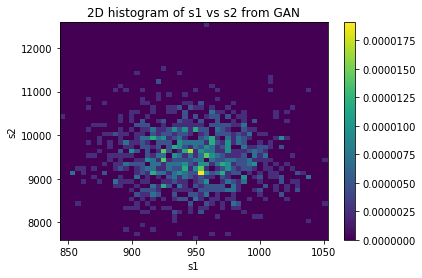

In [11]:
import tensorflow as tf
epochs_saved = []
acc = []
real_loss = []
real_acc = []
epoch_no = []
for e in range(epochs) :
    noise  = noisegenerator(batch_size, noise_size)

    batch_DS = train[np.random.choice(train.shape[0], batch_size, replace=True), :]
    #fake data made from predicting noise
    gen_DS   = g.predict(noise).reshape(batch_size, 2)
    
    #Real data has label [1.,0]
    real_label = np.array([[1., 0.] for i in range(batch_size)])
    
    #Fake data has label [0.,1.]
    fake_label = np.array([[0., 1.] for i in range(batch_size)])
    
    #Combine real and generated data
    X = np.concatenate([batch_DS  , gen_DS    ])
    Y = np.concatenate([real_label, fake_label])
    
    d.trainable = True
    d_loss, d_acc = d.train_on_batch(X, Y)

        
    noise  = noisegenerator(batch_size, noise_size)
    d.trainable = False
    gan.train_on_batch(noise, real_label)
    
    if e == 0 or (e+1) % 100 == 0 :
        noise  = noisegenerator(batch_size, noise_size)
        gen_DS = g.predict(noise)
        dis_loss, dis_acc = d.train_on_batch(X, Y)
        print("Discriminator loss: " + str(dis_loss))
        print("Discriminator acc: " + str(dis_acc))
        #print("Generator: " + gan.train_on_batch(noise, real_label))
        epoch_no.append(e)
        acc.append(d_acc)
        #x, y = np.hsplit(gen_DS, 2)
        x = np.asarray(gen_DS)[:,0]
        y = np.asarray(gen_DS)[:,1]
        #plt.scatter(x, y, label = "Generated Data")
        #plt.scatter(a1, a2, c = 'red', marker= 'x', label = "G4 Data")
        #plt.xlabel(f"Normalised S1")
        #plt.ylabel(f"Normalised S2")
        #plt.title(f"S1 vs S2 for epoch {e+1} with batch size {batch_size}")
        #plt.legend()

        plt.hist2d(x * s1.max(), y * s2.max(), bins=50, density=True)
        plt.xlabel(f"s1")
        plt.ylabel(f"s2")
        plt.title("2D histogram of s1 vs s2 from GAN")
        plt.colorbar()

        plt.show()
        real_loss.append(d_loss)
        real_acc.append(d_acc)
        epochs_saved.append(e+1)

## Plotting Discriminator Accuracy

As the generator gets better at fooling the disciminator, the accuracy of the disciminator should decrease, as it finds it harder to tell the difference.

In [12]:
len(real_loss)

41

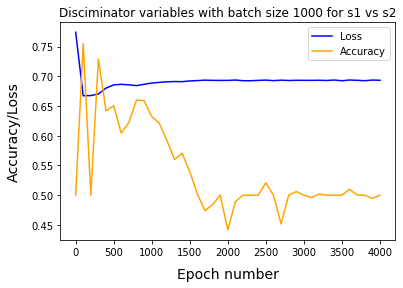

In [13]:
h3 = plt.plot(epoch_no,real_loss, color = 'blue', label = "Loss")
h4 = plt.plot(epoch_no,real_acc, color = 'orange', label = "Accuracy")
plt.xlabel("Epoch number", size=14, labelpad=10)
plt.ylabel("Accuracy/Loss", size=14, labelpad=10, rotation="vertical")
plt.title(f"Disciminator variables with batch size {batch_size} for s1 vs s2")
plt.legend(loc="upper right", fontsize=10)
plt.show()

## Checking 1D distributions

By learning 2D distributions, the 1D distributuon of s1 and s2 sepearately should also have been learnt. This is checked below, and uses a custom loss function which siply sums the differences in the sizes of the bins of the real and generated graphs.

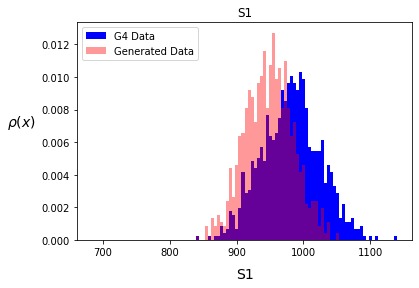

In [14]:
s1_true = plt.hist(a1 * s1.max(), density = True,range = (0.6* s1.max(),1* s1.max()), bins = 100,label = 'G4 Data',color="blue")
s1_gen = plt.hist(x * s1.max(), density = True,range = (0.6* s1.max(),1* s1.max()), alpha=0.4,bins = 100,label = 'Generated Data',color="red")
s1_diff = s1_true[0] - s1_gen[0]

sum_s1_diff = 0
for i in range(len(s1_diff)):
  sum_s1_diff += abs(s1_diff[i])

plt.legend(loc="upper left", fontsize=10)
plt.xlabel("S1", size=14, labelpad=10)
plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=20, rotation="horizontal")
plt.title("S1")
plt.show()


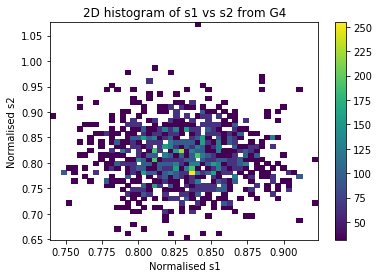

In [15]:
plt.hist2d(x, y, bins=50,cmin = 1, density=True)
plt.xlabel(f"Normalised s1")
plt.ylabel(f"Normalised s2")
plt.title("2D histogram of s1 vs s2 from G4")
plt.colorbar()
plt.show()

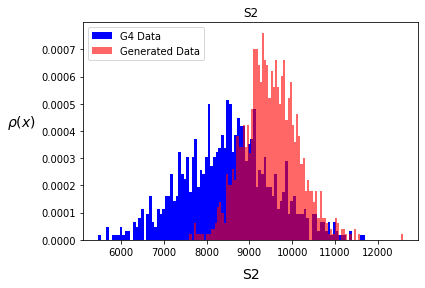

In [16]:
train_DS2 = a2
s2_true = plt.hist(a2 * s2.max(), density = True, bins = 100,label = 'G4 Data',color="blue")
s2_gen = plt.hist(y * s2.max(), density = True,alpha = 0.6, bins = 100,label = 'Generated Data',color="red")
plt.xlabel(f"s2")
plt.ylabel("Density of points")
plt.title("Distribution of s2 Energy")
s2_diff = s2_true[0] - s2_gen[0]


sum_s2_diff = 0
for i in range(len(s1_diff)):
  sum_s2_diff += abs(s2_diff[i])


plt.legend(loc="upper left", fontsize=10)
plt.xlabel("S2", size=14, labelpad=10)
plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=20, rotation="horizontal")
plt.title("S2")
plt.show()

3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


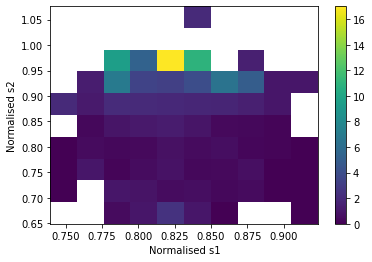

s1 difference is: 0.15043901166707913
s2_difference is: 0.013295817191614843


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [17]:
#s1_diff = s1_true - s1_gen
#s2_diff = s2_true - s2_gen
fig, ax = plt.subplots()
#plt.hist2d(s1_diff, s2_diff, bins=50, cmin = 0.001, density=True)
#plt.xlabel(f"Normalised s1")
#plt.ylabel(f"Normalised s2")
#plt.title("2D histogram of s1 vs s2 from G4")
#plt.colorbar()
print(len(s1_true))
h1, xedges, yedges = np.histogram2d(a1, a2, bins = 10)
h2, xedges, yedges = np.histogram2d(x, y, bins = 10)
h = h1 / h2
pc = ax.pcolorfast(xedges, yedges, h.T)
ax.set_xlabel(f"Normalised s1")
ax.set_ylabel(f"Normalised s2")
fig.colorbar(pc, ax=ax)
plt.show()

h = h1 / h2
pc = ax.pcolorfast(xedges, yedges, h.T)
sum_s1_diff = 0
sum_s2_diff = 0
for i in range(len(s1_diff)):
  sum_s1_diff += abs(s1_diff[i])
  sum_s2_diff += abs(s2_diff[i])

print("s1 difference is: " + str(sum_s1_diff))
print("s2_difference is: " + str(sum_s2_diff))